# Towards scalabe submerged acuatic vegetation mapping using Sentinel-2 

## Intro

Submerged aquatic vegetation (SAV) in shallow waters can, to some extent, be mapped using satellite imagery because seafloor components interact with light in distinct, wavelength-dependent ways. Seagrass, algae, and sediments generate characteristic optical responses related to their pigments, structure, and composition. When the water column is sufficiently shallow and clear to allow light to reach the bottom and return to the surface, these spectral differences can be detected by satellite sensors, enabling underwater vegetation to be distinguished from other benthic covers.

Sentinel-2 Level-2A products provide valuable information for studying the ecology of coastal seafloor habitats. In particular, Bands 1 to 4, which have the greatest penetration in the water column, can be used to infer the presence of submerged aquatic vegetation (SAV) when waters are sufficiently clear and shallow to allow reliable retrieval of bottom reflectance. However, determining whether the spectral signatures of different SAV types are sufficiently distinct, as observed by the MSI sensor onboard the Sentinel-2 satellites, and not excessively attenuated by the water column to enable discrimination among vegetation types, remains a challenge. Addressing this limitation requires high-quality in situ reference data to properly characterize benthic optical properties and evaluate the separability of SAV types.

In this notebook, we explore the potential of the Copernicus Data Space Ecosistem (CDSE), together with [extensive field data collected by the Seagrass Ecology Group](https://coastal-ai.github.io/GEAM_GEODATABASE/) of the Spanish Institute of Oceanography (IEO-CSIC)  to overcome this limitation and map SAV in the Tabarca Marine Reserve, a coastal protected area in the Spanish Mediterranean.

## Fetching S2 L2A zarr data

### Libraries

In [1]:
import os
import dask
import xarray as xr
from xcube.core.store import new_data_store
from xcube.util.config import load_configs
from xcube.webapi.viewer import Viewer
from xcube_resampling.utils import reproject_bbox
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
from pystac_client import CollectionSearch
from matplotlib.gridspec import GridSpec
import geopandas as gpd
from shapely.geometry import box
import folium

### Test region

In [2]:
bbox = [-0.70559054,38.09229916,-0.27444542,38.40081736]
crs_wgs84 = "EPSG:4326"
crs_utm = "EPSG:32631"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)
time_range = ["2025-01-01", "2025-05-15"]

# Center of the bbox
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2

# Create folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

# Add bbox as a rectangle
folium.Rectangle(
    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
    color="red",
    fill=False,
    weight=2,
    tooltip="AOI"
).add_to(m)

m

### pystac API search

In [3]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
# Search with cloud cover filter
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=time_range,
        query={"eo:cloud_cover": {"lt": 10}},  # Cloud cover less than 20%
    ).items()
)
print(len(items))

5


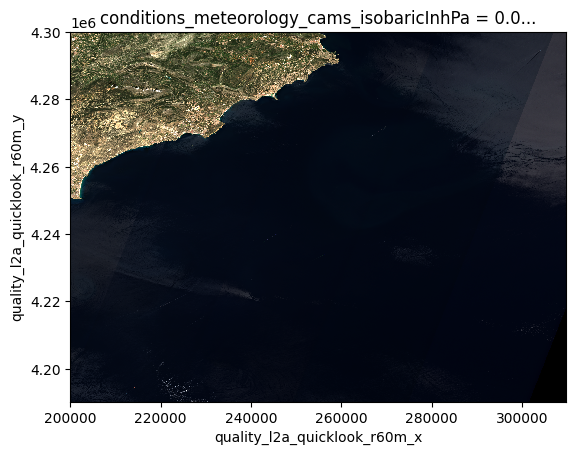

In [4]:
item = items[0]  # extracting the first item

ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)  # The engine="eopf-zarr" is already embedded in the STAC metadata

ds.quality_l2a_quicklook_r60m_tci.plot.imshow(rgb="quality_l2a_quicklook_r60m_band")

### xcube

In [5]:
xr.set_options(display_expand_attrs=False)
store = new_data_store("eopf-zarr")
store.list_data_ids()

['sentinel-2-l1c',
 'sentinel-2-l2a',
 'sentinel-3-olci-l1-efr',
 'sentinel-3-olci-l2-lfr',
 'sentinel-3-slstr-l1-rbt',
 'sentinel-3-slstr-l2-lst']

In [6]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm, # bbox in degrees can also be used
    time_range=time_range,
    spatial_res=10, # in that case convert m to degrees: 10 / 111320 
    crs=crs_utm, # and change to EPSG:4326
    variables=["b01", "b02", "b03", "b04", "scl"],
)
ds

CPU times: user 7.37 s, sys: 907 ms, total: 8.28 s
Wall time: 2min 41s


<xarray.Dataset> Size: 4GB
Dimensions:      (time: 8, x: 3904, y: 3568)
Coordinates:
  * time         (time) datetime64[ns] 64B 2025-04-04T10:46:41.025000 ... 202...
  * x            (x) float64 31kB 1.75e+05 1.75e+05 ... 2.14e+05 2.14e+05
  * y            (y) float64 29kB 4.257e+06 4.257e+06 ... 4.221e+06 4.221e+06
    spatial_ref  int64 8B 0
Data variables:
    b02          (time, y, x) float64 891MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, y, x) float64 891MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, y, x) float64 891MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b01          (time, y, x) float64 891MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 111MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 8.58 s, sys: 1.57 s, total: 10.2 s
Wall time: 27.7 s


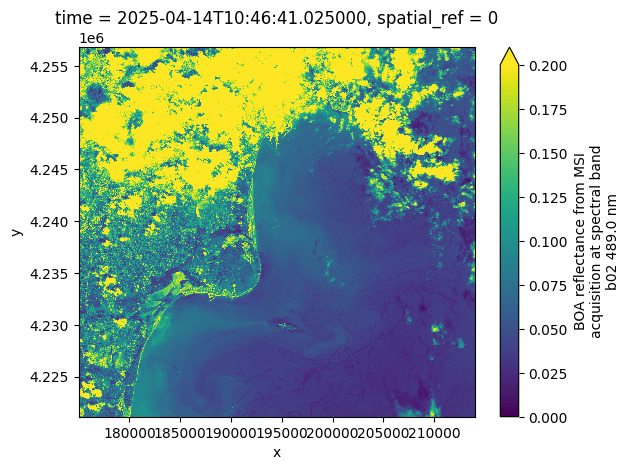

In [7]:
%%time
ds.b02.isel(time=3).plot(vmin=0, vmax=0.2)

### xcube viewer

In [ ]:
#if running in jupyter lab
#os.environ["XCUBE_JUPYTER_LAB_URL"] = ( "https://jupyterhub.user.eopf.eodc.eu/user/f.garcia@ieo.csic.es/")	
viewer = Viewer()
viewer.add_dataset(ds)
viewer.show()

### Cloud masking

In [8]:
cloud_mask = np.logical_not(ds["scl"].isin([8, 9, 3]))

ds = ds.where(cloud_mask)

### Land masking

In [9]:
land_mask = ds["scl"] == 6
ds = ds.where(land_mask)

### Monthly composite

In [10]:
monthly_median = ds.groupby("time.month").median().to_dataarray(dim="bands")
monthly_median

<xarray.DataArray (bands: 5, month: 2, y: 3568, x: 3904)> Size: 1GB
dask.array<stack, shape=(5, 2, 3568, 3904), dtype=float64, chunksize=(1, 1, 1528, 1567), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 31kB 1.75e+05 1.75e+05 ... 2.14e+05 2.14e+05
  * y            (y) float64 29kB 4.257e+06 4.257e+06 ... 4.221e+06 4.221e+06
  * month        (month) int64 16B 4 5
  * bands        (bands) object 40B 'b02' 'b03' 'b04' 'b01' 'scl'
Attributes: (4)

In [11]:
monthly_median = monthly_median.compute()
monthly_median

ServerDisconnectedError: Server disconnected

In [ ]:
monthly_median.loc[dict(bands=["b04", "b03", "b02"])][:, 0].plot.imshow(vmin=0, vmax=0.25) # change 0 by 1, etc for other months

### Median composite

In [12]:
composite = ds.median(dim="time").to_dataarray(dim="bands")
composite

<xarray.DataArray (bands: 5, y: 3568, x: 3904)> Size: 557MB
dask.array<stack, shape=(5, 3568, 3904), dtype=float64, chunksize=(1, 1429, 1466), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 31kB 1.75e+05 1.75e+05 ... 2.14e+05 2.14e+05
  * y            (y) float64 29kB 4.257e+06 4.257e+06 ... 4.221e+06 4.221e+06
  * bands        (bands) object 40B 'b02' 'b03' 'b04' 'b01' 'scl'

In [13]:
composite = composite.compute()
composite

<xarray.DataArray (bands: 5, y: 3568, x: 3904)> Size: 557MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.0425    ,
         0.03175   , 0.03055   ],
        [       nan,        nan,        nan, ..., 0.04064175,
         0.04221513, 0.04064953],
        ...,
        [       nan,        nan,        nan, ..., 0.04199094,
         0.04217997, 0.03805   ],
        [       nan,        nan,        nan, ..., 0.04161101,
         0.03914321, 0.03615   ],
        [       nan,        nan,        nan, ..., 0.03835138,
         0.03498079, 0.0345    ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.0265    ,
         0.0207    , 0.02025   ],
        [       nan,        nan,        nan, ..., 0.02874524,
         0.03011884, 0.02980278],
...
        [       nan,        nan,        nan, ..., 0.04116984,
         0.04117216, 0.04516563],
        [       nan,        nan,        nan, ..., 0.04091656,
         0.04095582, 0.04517188],
        [       nan,        nan,        nan, ..., 0.04074727,
         0.04080362, 0.04514375]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ..., 6.        ,
         6.        , 6.        ],
        [       nan,        nan,        nan, ..., 6.        ,
         6.        , 6.        ],
        ...,
        [       nan,        nan,        nan, ..., 6.        ,
         6.        , 6.        ],
        [       nan,        nan,        nan, ..., 6.        ,
         6.        , 6.        ],
        [       nan,        nan,        nan, ..., 6.        ,
         6.        , 6.        ]]])
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 31kB 1.75e+05 1.75e+05 ... 2.14e+05 2.14e+05
  * y            (y) float64 29kB 4.257e+06 4.257e+06 ... 4.221e+06 4.221e+06
  * bands        (bands) object 40B 'b02' 'b03' 'b04' 'b01' 'scl'

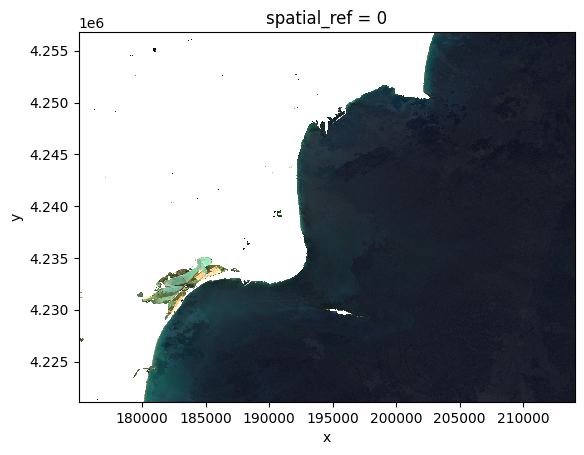

In [14]:
composite.loc[dict(bands=["b04", "b03", "b02"])].plot.imshow(vmin=0, vmax=0.25)

### To GeoTiff

In [ ]:
import rioxarray
# Save to GeoTIFF
composite.rio.to_raster("tabarca_composite.tif")

### From here proceed with the analysis as usual